```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```


# Inversion of Total Magnetic Intensity Data to Recover a Susceptibility Model

</br>

**Author:** Devin C. Cowan

</br>

**Keywords:** total magnetic intensity, integral formulation, inversion, sparse norm, tensor mesh, tree mesh.

</br>

**Summary:** Here we invert total magnetic intensity data to recover a susceptibility model. We demonstrate two approaches for recovering a susceptibility model:

1. Weighted least-squares inversion for a tensor mesh
2. Iteratively re-weighted least-squares (IRLS) inversion for a tree mesh

The *weighted least-squares* approach is a great introduction to geophysical inversion with SimPEG. One drawback however, is that it recovers smooth structures which may not be representative of the true model. To recover sparse and/or blocky structures, we demonstrate the *iteratively re-weighted least-squares* approach. Because this tutorial focusses primarily on 
inversion-related functionality, we urge the reader to become familiar with functionality explained in the [Forward simulation of total magnetic intensity data on a tensor mesh](fwd_magnetics_anomaly_3d.ipynb) tutorial before working through this one.

For this tutorial, we focus on:

- Assigning appropriate uncertainties to total magnetic intensity data
- Designing a suitable mesh for magnetic inversion
- Defining the inverse problem (data misfit, regularization, optimization)
- Choosing suitable parameters for the inversion
- Specifying directives that are applied throughout the inversion
- Sensitivity weighting
- Inversion with weighted least-squares and sparse-norms
- Analyzing inversion outputs

Although we consider total magnetic intensity data in this tutorial, the same approach can be used to invert magnetic gradiometry data.

## Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise.
All of the functionality specific to the forward simulation of magnetic data are imported from ``SimPEG.potential_fields.magnetics``. Classes required to define the data misfit, regularization, optimization problem, etc... are imported from elsewhere within SimPEG. We also import some useful utility functions.
To generate the mesh used for the inversion, we use the ``discretize`` package.

In [1]:
# SimPEG functionality
from SimPEG.potential_fields import magnetics
from SimPEG.utils import plot2Ddata, model_builder, download
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion
)

# discretize functionality
from discretize import TensorMesh, TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
mpl.rcParams.update({'font.size': 14})

## Load Data and Plot

For most geophysical inversion projects, a reasonable inversion result can be obtained so long as the practitioner has observed data and topography. For this tutorial, the observed data and topography files are stored within a
tar-file on our Google cloud bucket: 
"https://storage.googleapis.com/simpeg/doc-assets/magnetics.tar.gz". Here, we download and import the observed data and topography into the SimPEG framework.

In [2]:
# storage bucket where we have the data
data_source = "https://storage.googleapis.com/simpeg/doc-assets/magnetics.tar.gz"

# download the data
downloaded_data = download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "magnetics_topo.txt"
data_filename = dir_path + "magnetics_data.obs"

   saved to: D:\Documents\Repositories\user-tutorials\notebooks\04-magnetics\magnetics.tar.gz
Download completed!


For this tutorial, the data are organized within basic XYZ files. However, SimPEG does allow the user to import UBC-GIF formatted magnetic data files. The `read_mag3d_ubc` function can be imported from ``SimPEG.utils.io_utils``. 

In [3]:
# Load topography (xyz file)
topo_xyz = np.loadtxt(str(topo_filename))

# Load field data (xyz file)
dobs = np.loadtxt(str(data_filename))

## Plot Observed Data and Topography

Here we plot the synthetic total magnetic intensity data and local topography.

In [4]:
# Define receiver locations and observed data
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

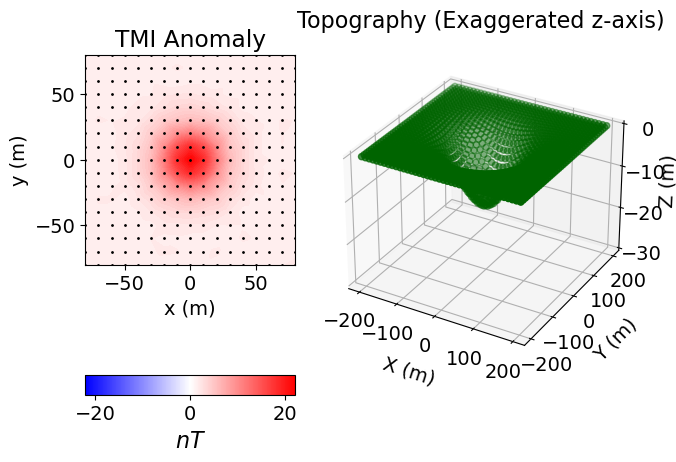

In [5]:
fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.6])

v_max = np.max(np.abs(dobs))
norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)

plot2Ddata(
    receiver_locations,
    dobs,
    ax=ax1,
    dataloc=True,
    ncontour=40,
    contourOpts={"cmap": mpl.cm.bwr, "norm": norm},
)
ax1.set_title("TMI Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

cx1 = fig.add_axes([0.05, 0.18, 0.35, 0.04])
cbar1 = mpl.colorbar.ColorbarBase(
    cx1, norm=norm, orientation="horizontal", cmap=mpl.cm.bwr
)
cbar1.set_label("$nT$", size=16)

ax2 = fig.add_axes([0.42, 0.1, 0.58, 0.9], projection='3d')
ax2.set_zlim([-30, 0])
ax2.scatter3D(topo_xyz[:, 0], topo_xyz[:, 1], topo_xyz[:, 2], c='darkgreen')
ax2.set_box_aspect(aspect=None, zoom=0.9)
ax2.set_xlabel('X (m)', labelpad=10)
ax2.set_ylabel('Y (m)', labelpad=10)
ax2.set_zlabel('Z (m)', labelpad=2)
ax2.set_title('Topography (Exaggerated z-axis)', fontsize=16)
ax2.view_init(elev=30.)

plt.show()

## Assign Uncertainties

Inversion with SimPEG requires that we define the uncertainties on our data; that is, an estimate of the standard deviation of the noise on our data assuming it is uncorrelated Gaussian with zero mean. An online resource explaining uncertainties and their role in the inversion can be found [here](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).

**For total magnetic intensity data,** a constant floor value is generally applied to all data. We generally avoid assigning percent uncertainties because the inversion prioritizes fitting the background over fitting anomalies. The floor value for the uncertainties may be chosen based on some knowledge of the instrument error, or it may be chosen as some fraction of the largest anomaly value. For this tutorial, the floor uncertainty assigned to all data is 2% of the maximum observed total magnetic intensity value. **For magnetic gradiometry data,** you may choose to assign a different floor value to each data component. 

In [6]:
maximum_anomaly = np.max(np.abs(dobs))
floor_uncertainty = 0.02 * maximum_anomaly
uncertainties = floor_uncertainty * np.ones(np.shape(dobs))
print('Floor uncertainty: {}'.format(floor_uncertainty))

Floor uncertainty: 0.44214


## Defining the Survey

Here, we define the survey geometry. The survey consists of a 160 m x 160 m grid of equally spaced receivers located 10 m
above the surface topography. For a more comprehensive description of constructing magnetic surveys in SimPEG, see the [Forward simulation of total magnetic intensity data on a tensor mesh](fwd_magnetics_anomaly_3d.ipynb) tutorial.

In [7]:
# Define the component(s) of the field we are inverting as a list. Here we will
# invert total magnetic intensity data.
components = ["tmi"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)
receiver_list = [receiver_list]

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
inclination = 90
declination = 0
strength = 50000
inducing_field = (strength, inclination, declination)

source_field = magnetics.sources.UniformBackgroundField(
    receiver_list=receiver_list, parameters=inducing_field
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

## Defining the Data

The ``Data`` class in SimPEG is required for inversion and connects the observed data, uncertainties and survey geometry.

In [8]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

## Weighted Least-Squares Inversion on a Tensor Mesh

### Designing a (Tensor) Mesh

Meshes are designed using the ``discretize`` package. See the [discretize user tutorials](https://discretize.simpeg.xyz/en/main/tutorials/mesh_generation/index.html) to learn more about creating meshes. When designing a mesh for magnetic inversion, we must consider the spatial wavelengths of the signals contained within the data. If the data spacing is large and/or the signals present in the data are smooth, larger cells can be used to construct the mesh. If the data spacing is smaller and compact anomalies are observed, smaller cells are needed to characterize the structures responsible. And smaller cells are required when the effects of surface topography are significant.

**General rule of thumb:** The minimum cell size is at most 0.5 - 1 times the station spacing. And the thickness of the padding is at least 1 - 2 times the width of the survey region.

In [9]:
dh = 5.0                                      # minimum cell size
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]  # discretization along x
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]  # discretization along y
hz = [(dh, 5, -1.3), (dh, 15)]                # discretization along z
tensor_mesh = TensorMesh([hx, hy, hz], "CCN")

### Active Cells and Mapping from the Model to Active Cells

Whereas cells below the Earth's surface contribute towards simulated magnetic anomalies, air cells do not.
The set of mesh cells used in the forward simulation are referred to as 'active cells'. Unused cells (air cells) are 'inactive cells'. Here, a utility function within SimPEG is used to find the indices of the active cells using the mesh and surface topography.

In [10]:
ind_tensor_active = active_from_xyz(tensor_mesh, topo_xyz)

In SimPEG, the term 'model' is not synonymous with the physical property values defined on the mesh. For whatever model we choose, we must define a mapping from the set of model parameters to the active cells in the mesh. Mappings are created using the ``SimPEG.maps`` module. For the tutorial exercise, the model is the susceptibility values for all active cells. As such, our mapping is an identity mapping, whose dimensions are equal to the number of active cells.

In [11]:
nP_tensor = int(ind_tensor_active.sum())           # number of active cells
tensor_model_map = maps.IdentityMap(nP=nP_tensor)  # mapping from model to active cells

### Starting/Reference Models

The **starting model** defines a reasonable starting point for the inversion and does not necessarily represent an initial estimate of the true model. Because the integral formulation used to solve the magnetic forward simulation is linear, the optimization problem we must solve is a linear least-squares problem, making the choice in starting model insignificant. It should be noted that the staring model **cannot be vector of zeros,** otherwise the inversion will be unable to compute a gradient direction at the first iteration. For magnetic inversion, the starting model is frequently a constant vector with a very small value.

The **reference model** is used to include a-prior information. The impact of the reference model on the inversion will be discussed in another tutorial. Assuming the contribution from all regional structures has been removed from the magnetic data, and assuming we have not a-priori information, the reference model for basic inversion of magnetic data is zero or equal to the starting model.

Notice that the length of the starting and reference models is equal to the number of active mesh cells!!!

In [12]:
starting_tensor_model = 1e-6 * np.ones(nP_tensor)
reference_tensor_model = np.zeros_like(starting_tensor_model)

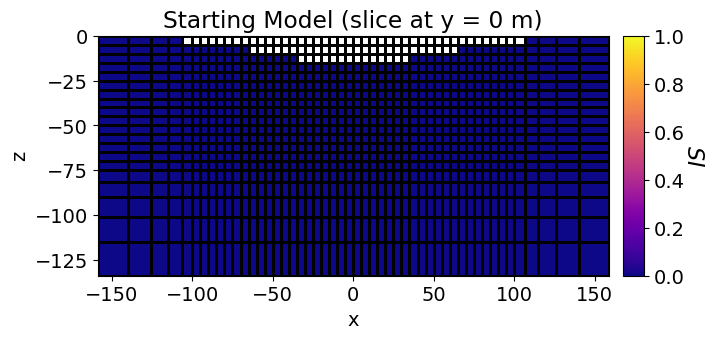

In [13]:
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

tensor_plotting_map = maps.InjectActiveCells(
    tensor_mesh, ind_tensor_active, np.nan
)
norm = mpl.colors.Normalize(vmin=0., vmax=1.)
tensor_mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
)
ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("$SI$", rotation=270, labelpad=15, size=16)

plt.show()

### Define the Forward Simulation

A simulation object defining the forward problem is required in order to predict data and calculate misfits for recovered models. A comprehensive description of the simulation object for total magnetic intensity data was discussed in the [Forward simulation of total magnetic intensity data on a tensor mesh](fwd_magnetics_anomaly_3d.ipynb) tutorial.

In [14]:
simulation_L2 = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=tensor_mesh,
    model_type="scalar",
    chiMap=tensor_model_map,
    ind_active=ind_tensor_active
)

### Data Misfit

To understand the role of the data misfit in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).
Here, we define the data misfit as the L2 norm of the weighted residual between the observed data and the data predicted for a given model. When instantiating the data misfit object within SimPEG, we must assign an appropriate *data object* and *simulation object* as properties.

In [15]:
dmis_L2 = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_L2)

### Regularization

To understand the role of the regularization in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/ObjectiveFunction.html). Here, we use a weighted least-squares regularization to constrain the inversion result.

In [16]:
reg_L2 = regularization.WeightedLeastSquares(
    tensor_mesh,
    active_cells=ind_tensor_active,
    length_scale_x=1.0,
    length_scale_y=1.0,
    length_scale_z=1.0,
    reference_model=reference_tensor_model,
    reference_model_in_smooth=False
)

### Optimization

In [17]:
opt_L2 = optimization.ProjectedGNCG(
    maxIter=100,
    lower=0.,
    maxIterLS=20,
    maxIterCG=10,
    tolCG=1e-2
)

### Inverse Problem

Here we define the inverse problem that is to be solved

In [18]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

### Inversion Directives

Here we define any directiveas that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.

In [19]:
# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

update_jacobi = directives.UpdatePreconditioner(update_every_iteration=False)

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)

# Defines the rate at which beta is reduced at every iteration.
beta_schedule = directives.BetaSchedule(coolingFactor=2., coolingRate=1)

# Stopping criteria. Inversion ends when data misfit equals number of data.
target_misfit = directives.TargetMisfit(chifact=1.0)

# The directives are defined as a list.
directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit
]

### Define and Run the Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.

In [20]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run inversion
recovered_tensor_model = inv_L2.run(starting_tensor_model)


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.85e+05  1.39e+04  1.51e-07  1.39e+04    8.81e+05      0              
   1  1.92e+05  1.47e+03  4.00e-03  2.24e+03    2.40e+05      0              
   2  9.62e+04  3.39e+02  6.60e-03  9.75e+02    9.28e+04      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.3871e+03
1 : |xc-x_last| = 9.2293e-03 <= tolX*(1+|x0|) = 1.0002e-01
0 : |proj(x-g)-x|    = 9.2844e+04 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 9.2844e+04 <= 1e3*eps       = 1.000

## Analysing Inversion Outputs

### Convergence

### Plot Data Misfit

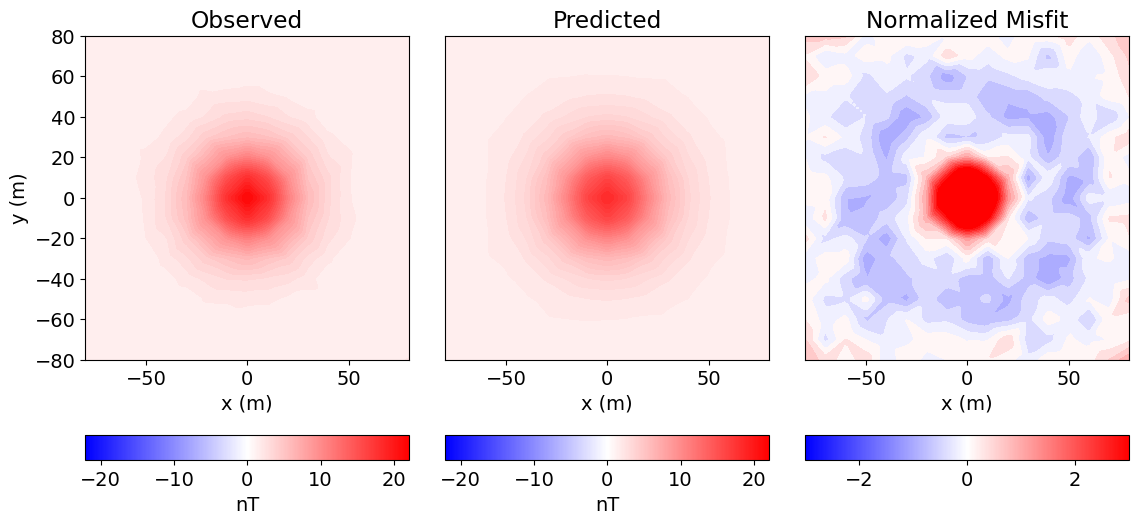

In [36]:
# Predicted data with final recovered model.
dpred = inv_prob_L2.dpred

# Observed data | Predicted data | Normalized data misfit
data_array = np.c_[dobs, dpred, (dobs - dpred) / uncertainties]

fig = plt.figure(figsize=(12, 5))
plot_title = ["Observed", "Predicted", "Normalized Misfit"]
plot_units = ["nT", "nT", ""]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), 3]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.3 * ii + 0.1, 0.2, 0.27, 0.75])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        contourOpts={"cmap": "bwr", "norm": norm[ii]},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    if ii == 0:
        ax1[ii].set_ylabel("y (m)")
    else:
        ax1[ii].set_yticks([])

    ax2[ii] = fig.add_axes([0.3 * ii + 0.1, 0.05, 0.27, 0.05])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="horizontal", cmap=mpl.cm.bwr
    )
    cbar[ii].set_label(plot_units[ii], labelpad=5)

plt.show()

### Plot Recovered Model

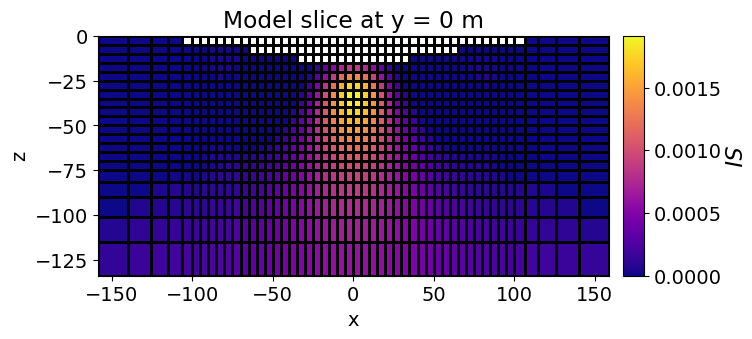

In [22]:
# Plot Recovered Model
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tensor_model), vmax=np.max(recovered_tensor_model)
)
tensor_mesh.plot_slice(
    tensor_plotting_map * recovered_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("$SI$", rotation=270, labelpad=15, size=16)

plt.show()

## Iteratively Re-weighted Least-Squares Inversion

### Tree Mesh

In [23]:
dx = 5  # minimum cell width (base tree_mesh cell width) in x
dy = 5  # minimum cell width (base tree_mesh cell width) in y
dz = 5  # minimum cell width (base tree_mesh cell width) in z

x_length = 240.0  # domain width in x
y_length = 240.0  # domain width in y
z_length = 120.0  # domain width in z

# Compute number of base tree_mesh cells required in x and y
nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# Define the base tree_mesh
hx = [(dx, nbcx)]
hy = [(dy, nbcy)]
hz = [(dz, nbcz)]
tree_mesh = TreeMesh([hx, hy, hz], x0="CCN")

# Refine based on surface topography
tree_mesh.refine_surface(
    topo_xyz, padding_cells_by_level=[2, 2], finalize=False
)

# Refine box based on region of interest
wsb_corner = np.c_[-100, -100, -80]
ent_corner = np.c_[100, 100, 0]
# Note -1 is a flag for smallest cell size
tree_mesh.refine_box(wsb_corner, ent_corner, levels=[-1], finalize=False)

tree_mesh.finalize()

### Active Cells and Mapping from Model to Active Cells

In [24]:
ind_tree_active = active_from_xyz(tree_mesh, topo_xyz)

In [25]:
nP_tree = int(ind_tree_active.sum())           # number of active cells
tree_model_map = maps.IdentityMap(nP=nP_tree)  # mapping from model to active cells

### Starting and Reference Models

In [26]:
starting_tree_model = 1e-6 * np.ones(nP_tree)
reference_tree_model = np.zeros_like(starting_tree_model)

### Define Forward Simulation

In [27]:
simulation_irls = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=tree_mesh,
    model_type="scalar",
    chiMap=tree_model_map,
    ind_active=ind_tree_active
)

### Define Data Misfit

In [28]:
dmis_irls = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_irls)

### Regularization

In [29]:
reg_irls = regularization.Sparse(
    tree_mesh,
    active_cells=ind_tree_active,
    alpha_s=dh**-2,
    alpha_x=1,
    alpha_y=1,
    alpha_z=1,
    reference_model=reference_tree_model,
    reference_model_in_smooth=False,
    norms=[0, 1, 1, 1]
)

### Optimization

In [30]:
opt_irls = optimization.ProjectedGNCG(
    maxIter=100,
    lower=-1.0,
    upper=1.0,
    maxIterLS=20,
    maxIterCG=10,
    tolCG=1e-2
)

### Inverse Problem

In [31]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

### Directives

In [32]:
sensitivity_weights_irls = directives.UpdateSensitivityWeights(every_iteration=False)
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=10)

update_irls = directives.Update_IRLS(
    coolingFactor=2,
    f_min_change=1e-4,
    max_irls_iterations=25,
    chifact_start=1.0,
#     coolEpsFact=1.5,
#     beta_tol=1e-2,
)

update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)

# The directives are defined as a list.
directives_list_irls = [
    update_irls,
    sensitivity_weights_irls,
    starting_beta_irls,
    update_jacobi_irls
]

In [33]:
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)

recovered_tree_model = inv_irls.run(starting_tree_model)


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.23e+07  1.39e+04  6.15e-09  1.39e+04    1.91e+02      0              
   1  4.62e+07  4.87e+03  3.19e-05  6.34e+03    1.91e+02      0              
   2  2.31e+07  2.94e+03  6.16e-05  4.36e+03    1.91e+02      0   Skip BFGS  
   3  1.15e+07  1.55e+03  1.04e-04  2.75e+03    1.91e+02      0   Skip BFGS  
   4  5.77e+06  7.15e+02  1.54e-04  1.61e+03    1.90e+02      0   Skip BFGS  
   5  2.89e+06  2.93e+02  2.05e-04  8.84e+02    1.88e+02      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start IR

## Comparing L2 and IRLS Models

### Recreate True Model on a Tensor Mesh

In [34]:
background_susceptibility = 0.0001
sphere_susceptibility = 0.01

true_model = background_susceptibility * np.ones(nP_tensor)
ind_sphere = model_builder.get_indices_sphere(
    np.r_[0.0, 0.0, -45.0], 15.0, tensor_mesh.cell_centers[ind_tensor_active]
)
true_model[ind_sphere] = sphere_susceptibility

## Plotting True Model and Recovered Model




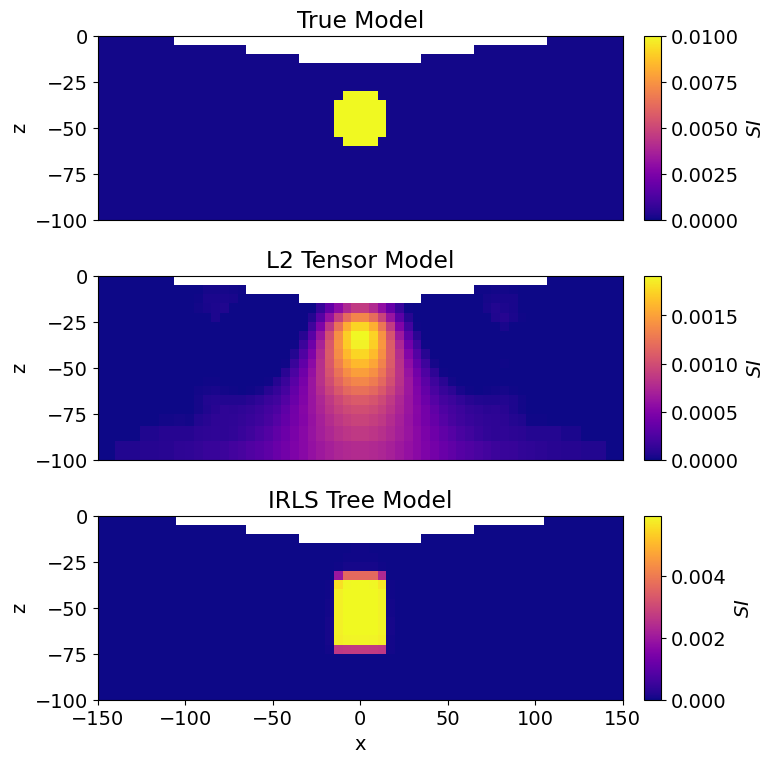

In [35]:
mesh_list = [tensor_mesh, tensor_mesh, tree_mesh]
ind_list = [ind_tensor_active, ind_tensor_active, ind_tree_active]
model_list = [true_model, recovered_tensor_model, recovered_tree_model]
title_list = ['True Model', 'L2 Tensor Model', 'IRLS Tree Model']
cplot = 3 * [None]
cbar = 3 * [None]
norm = 3 * [None]

fig = plt.figure(figsize=(7, 8))
ax1 = [fig.add_axes([0.1, 0.7-0.3*ii, 0.75, 0.23]) for ii in range(0, 3)]
ax2 = [fig.add_axes([0.88, 0.7-0.3*ii, 0.025, 0.23]) for ii in range(0, 3)]

for ii, mesh in enumerate(mesh_list):
    
    plotting_map = maps.InjectActiveCells(mesh, ind_list[ii], np.nan)
    max_abs = np.max(np.abs(model_list[ii]))
    norm[ii] = mpl.colors.Normalize(vmin=0., vmax=max_abs)
    
    cplot[ii] = mesh.plot_slice(
        plotting_map * model_list[ii],
        normal="Y",
        ax=ax1[ii],
        ind=int(mesh.shape_cells[1] / 2),
        grid=False,
        pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm[ii]},
    )
    ax1[ii].set_xlim([-150, 150])
    ax1[ii].set_ylim([-100, 0])
    if ii < 2:
        ax1[ii].set_xlabel("")
        ax1[ii].set_xticks([])
    ax1[ii].set_title(title_list[ii])
    
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="vertical", cmap=mpl.cm.plasma
    )
    cbar[ii].set_label("$SI$", labelpad=5)